In [1]:
% matplotlib inline

import torch
import torch.nn as nn
import numpy as np

# Load Data
data_path = '../data/processed/'
X = np.load(data_path + 'X.npy')
y = np.load(data_path + 'y.npy')
print("X has shape: {}\ny has shape: {}".format(X.shape, y.shape))
X_torch = torch.from_numpy(X).float()
y_torch = torch.from_numpy(y).float()

# Calculate global optimum a.k.a c from appendix A in the paper
# P.S. @ in python 3.5+ means matrix multiplication
m = len(y_torch)
cross_cov = (1 / m) * y_torch.transpose(0,1) @ X_torch # (1, 128)
y_cov = (1 / m) * y_torch.transpose(0,1) @ y_torch
global_opt = -0.5 * (cross_cov @ cross_cov.transpose(0,1)) + 0.5 * y_cov 
global_opt 

X has shape: (2565, 128)
y has shape: (2565, 1)


tensor([[1.0345]])

In [10]:
import sys
sys.path.append('../src/models/')
from linear_nn import three_layer_nn, fro_loss, train, eight_layer_nn

# Set seed
seed = 521
# seed = 123
torch.manual_seed(seed)

# Initalize Constants
learning_rates = [1e-4, 1e-3, 1e-2, 1e-1, 1e0]
eps = 1e-5 # Even though they say 1e-5 in the paper, this one works 


std = 1e-3
learning_rate = 0.5
model = three_layer_nn('normal', std) # Bug with dropout, getting delta is going to be a little more subtle
loss_fn = fro_loss()
train_iter, loss, deltas, norms = train(model, loss_fn, X_torch, y_torch, learning_rate, eps)
print(train_iter)
delta_max, delta_min = max(deltas), min(deltas)
print(deltas)

AttributeError: 'Dropout' object has no attribute 'weight'

Text(0.5, 1.0, 'sigma = 0.001')

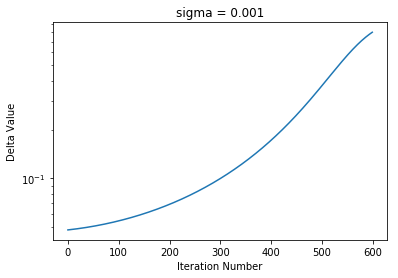

In [9]:
import matplotlib.pyplot as plt

iters = range(len(deltas))
plt.plot(iters[0:600], norms[0:600])
plt.xlabel('Iteration Number')
plt.ylabel('Delta Value')
# plt.ylabel('Min L Norm')
plt.yscale('log')
plt.title("sigma = {}".format(std))

In [ ]:
# Results of experiments of the above cell, I found a better learning rate than that in the paper
# For a lot of the stds

################################
# Three Layer
################################
# Normal
################################
# std = 1e-4, lr = 0.5, num_iters = 3734
# std = 1e-3, lr = 0.5, num_iters = 381
# std = 1e-2, lr = 0.5, num_iters = 44
# std = 1e-1, lr = 0.5, num_iters = 64
# std = 5e-1, lr = 0.5, num_iters = 17
#################################

################################
# Balanced
################################
# std = 1e-4, lr = 0.5, num_iters = 34
# std = 1e-3, lr = 0.5, num_iters = 19, lr = 1e-2, num_iters = 682 
# std = 1e-2, lr = 0.5, num_iters = 13
# std = 1e-1, lr = 0.5, num_iters = 12
# std = 1, lr = 1e-2, num_iters = 596
#################################

################################
# Eight Layer
################################
# Normal
################################
# std = 1e-4, DNC (Did Not Converge)
# std = 1e-3, DNC
# std = 5e-2, lr = 1e-1, num_iters = 2450
# std = 1e-1, lr = 1e-2, num_iters = 1265
# std = 5e-1, DNC
#################################

################################
# Balanced
################################
# std = 1e-4, lr = 1e-2, num_iters = 2349
# std = 1e-3, lr = 1e-2, num_iters = 681
# std = 1e-2, lr = 1e-2, num_iters = 504
# std = 1e-1, lr = 1e-2, num_iters = 692
# std = 1, lr = 5e-3, num_iters = 1161
#################################